# Example notebook 2

This notebook sketches the analysis of a finger tapping dataset with multiple subjects. A simple Linear Discriminant Analysis (LDA) classifier is trained to distinguish left and right fingertapping.

In [1]:
import cedalion
import cedalion.nirs
import cedalion.xrutils as xrutils
import numpy as np
import xarray as xr
import pint
import matplotlib.pyplot as p
import scipy.signal
import os.path

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score

xr.set_options(display_max_rows=3, display_values_threshold=50)
np.set_printoptions(precision=4)

### Loading raw CW-NIRS data from a SNIRF file

This notebook uses a finger-tapping dataset in BIDS layout provided by Rob Luke. Download it [here](https://github.com/rob-luke/BIDS-NIRS-Tapping) and point the variable `DATADIR` to its location.

In [2]:
DATADIR = "../../data/BIDS-NIRS-Tapping"

xarray provides another container: `xr.DataSet`. These are collections of `xr.DataArray` that share coordinate axes. These can be used to group different arrays with shared coordinate axes together.

In [3]:
subjects  = [f"sub-{i:02d}" for i in [1,2,3,4,5]]

# store data of different subjects in a dictionary
data = {} 
for subject in subjects:
    
    elements = cedalion.io.read_snirf(
        os.path.join(DATADIR, f"{subject}/nirs/{subject}_task-tapping_nirs.snirf")
    )

    amp = elements[0].data[0]
    stim = elements[0].stim # pandas Dataframe
    geo3d = elements[0].geo3d
    
    # cedalion registers an accessor (attribute .cd ) on pandas DataFrames
    stim.cd.rename_events( {
        "1.0" : "control",
        "2.0" : "Tapping/Left",
        "3.0" : "Tapping/Right"
    })
    
    dpf = xr.DataArray([6, 6], dims="wavelength", coords={"wavelength" : amp.wavelength})
    
    data[subject] = xr.Dataset(
        data_vars = {
            "amp" : amp,
            "od"  : - np.log( amp / amp.mean("time") ),
            "geo" : geo3d,
            "conc": cedalion.nirs.beer_lambert(amp, geo3d, dpf)
        },
        attrs={"stim" : stim}, # store stimulus data in attrs
        coords={"subject" : subject} # add the subject label as a coordinate
    )

Illustrate the dataset of one subject

In [4]:
display(data["sub-01"])

Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0941083 0.0940129 0.0944882] [0.1856806 0.186377 0.1836514 ... 0.1856486 0.1850836 0.1842172]] [[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] ... [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]] [[0.4885007 0.4802285 0.4818338 ... 0.6109142 0.6108118 0.613845] [0.8457658 0.825988 0.8259648 ... 0.975894 0.9756599 0.9826459]] [[0.6304559 0.6284427 0.6287045 ... 0.6810626 0.6809573 0.6818709] [1.2285622 1.2205907 1.2190002 ... 1.2729124 1.2727222 1.2755645]]]
Units,dimensionless
Magnitude,[[[0.040420720851589244 0.04460046098449573 0.0442158667266921 ... 0.010876348689028297 0.01189058853204466 0.006847636450666034] [0.023820496835156947 0.020076986081598715 0.03480909472899116 ... 0.023992850639162802 0.027040875264083337 0.031732993935654014]] [[-0.008280063468686781 -0.01784405593180633 -0.002198739340328898 ... -0.003592058220542012 -0.006742726672860488 -0.0047443982578777594] [-0.03725579234490354 -0.04067296052603699 -0.028261149412724014 ... 0.008275386235838757 0.005771141488662178 0.0051515177576299375]] [[0.1005582275517943 0.09914287354277777 0.11119025710690507 ... -0.02830701101541003 -0.023242770227372977 -0.023590421283804962] [0.04993799639529682 0.047551763623795935 0.06016311306879892 ... -0.005456229532249399 -0.0015308884573803712 -0.004733085331725723]] ... [[0.09543410489184105 0.11098678842280141 0.10684828479073329 ... -0.038599718102985896 -0.03566192105523218 -0.04378947818067423] [0.03858010875753767 0.06286432773409747 0.06128249638988582 ... 0.008314104856099373 0.007674359302522161 -0.0026751405572218796]] [[0.15506580435158798 0.17214467649471782 0.16880746748060918 ... -0.06854981498765861 -0.06838218329243445 -0.07333574448986935] [0.10250044669095155 0.12616269025036977 0.1261907782199553 ... -0.040611038136814874 -0.040371126750177955 -0.04750589562552556]] [[0.0580532188103781 0.06125157285758024 0.06083507429037254 ... -0.019157798285875216 -0.019003174994086804 -0.020343916456372766] [0.02437701777814723 0.030886638430615728 0.03219054575814673 ... -0.01108594305570406 -0.010936510768482734 -0.013167265399560904]]]
Units,dimensionless
Magnitude,[[-0.041613204679326624 0.026799775287857947 0.1299043936308115] [-0.06476686499872276 0.05814256998996063 0.0908425773727145] [-0.07120554551675068 -0.012874272652217859 0.10787860947691345] [-0.0859043654400404 0.018971698468891116 0.06509762433137256] [0.03694171596700852 0.02748380530252158 0.13022129709104263] [0.06065133742692848 0.05882414589197514 0.09117717995727878] [0.06712771392323756 -0.012199231886346213 0.1085725493643022] [0.08188685574250908 0.020427932162352107 0.06571325110115192] [-0.037619588707178915 0.06322851630256272 0.11572802770110814] [-0.04134445059646741 -0.011779611291995052 0.13495002938154654] [-0.07242424650162711 0.02347293206381116 0.10322218957482163] [-0.07912592748234686 0.05140929117919257 0.057370046083468226] [0.03352717285472944 0.06359968341212022 0.11583881331702946] [0.03686639505686032 -0.011397164907962862 0.13536724076864515] [0.06791592703520163 0.02468254467119271 0.10366605207860985] [0.075310088095807 0.05226884499005337 0.05787698428594235] [-0.03773895423262196 0.034082658086024245 0.1294919790818403] [-0.061454307897075164 0.06443800208211416 0.09061004226260877] [-0.07282878975853647 -0.00527870527992114 0.10743054838539287] [-0.08439610638498087 0.02706123378098264 0.06559510739262155] [0.040013338219712126 0.020439745814301982 0.13063767506528579] [0.06428020193514211 0.05162125732852231 0.09133632943784001] [0.06521393141744246 -0.019260368037897515 0.10880928230870081] [0.08272091030272573 0.012990608473329186 0.06658402323335233] [-0.082489991830

### Frequency filtering and splitting into epochs

In [5]:
for subject, ds in data.items():
    # cedalion registers the accessor .cd on DataArrays
    # to provide common functionality like frequency filters...
    ds["conc_freqfilt"] = ds["conc"].cd.freq_filter(fmin=0.02, fmax=0.5, butter_order=4)

    # ... or epoch splitting
    ds["cfepochs"] = ds["conc_freqfilt"].cd.to_epochs(
        ds.attrs["stim"], # stimulus dataframe
        ["Tapping/Left", "Tapping/Right"],  # select events
        before=5, # seconds before stimulus
        after=20  # seconds after stimulus
    )

### Plot frequency filtered data
Illustrate for a single subject and channel the effect of the bandpass filter.

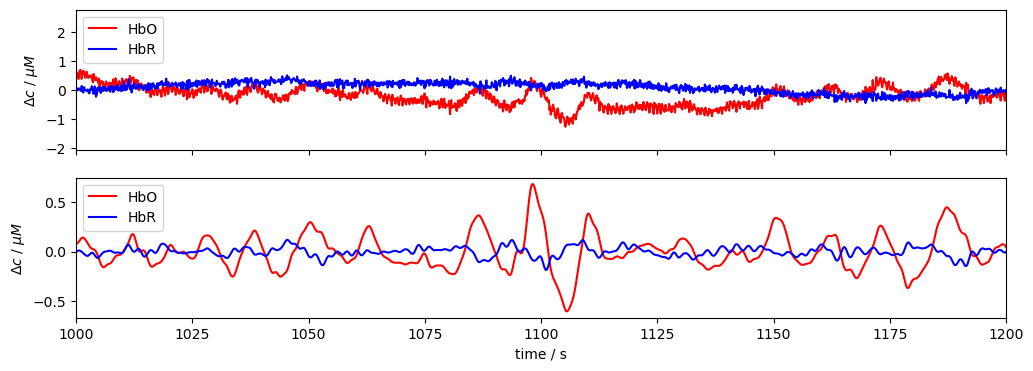

In [6]:
ds = data["sub-01"]
channel = "S5D7"

f,ax= p.subplots(2,1, figsize=(12,4), sharex=True)
ax[0].plot(ds.time, ds.conc.sel(channel=channel, chromo="HbO"), "r-", label="HbO")
ax[0].plot(ds.time, ds.conc.sel(channel=channel, chromo="HbR"), "b-", label="HbR")
ax[1].plot(ds.time, ds.conc_freqfilt.sel(channel=channel, chromo="HbO"), "r-", label="HbO")
ax[1].plot(ds.time, ds.conc_freqfilt.sel(channel=channel, chromo="HbR"), "b-", label="HbR")
ax[0].set_xlim(1000,1200)
ax[1].set_xlabel("time / s")
ax[0].set_ylabel("$\Delta c$ / $\mu M$")
ax[1].set_ylabel("$\Delta c$ / $\mu M$")
ax[0].legend(loc="upper left"); ax[1].legend(loc="upper left");

In [7]:
display(data["sub-01"]["cfepochs"])

<xarray.DataArray 'cfepochs' (epoch: 60, chromo: 2, channel: 28, reltime: 196)>
<Quantity([[[[-1.9479e-02 -1.9950e-02 -2.0945e-02 ... -1.9397e-01 -2.1930e-01
    -2.4552e-01]
   [-1.0442e-02 -1.1375e-02 -1.2845e-02 ... -2.5376e-01 -2.5998e-01
    -2.6454e-01]
   [-1.2500e-02 -8.8897e-03 -5.8429e-03 ... -2.1148e-01 -2.2557e-01
    -2.3975e-01]
   ...
   [ 9.5644e-02  1.0075e-01  1.0499e-01 ... -3.2907e-01 -3.4702e-01
    -3.6405e-01]
   [ 2.0733e-02  2.2404e-02  2.3932e-02 ... -2.9462e-01 -2.9954e-01
    -3.0371e-01]
   [ 1.4324e-03  2.0414e-03  4.1026e-03 ... -3.0974e-01 -3.2710e-01
    -3.4287e-01]]

  [[ 1.4641e-02  6.4301e-03 -1.6854e-03 ... -6.5363e-02 -6.2839e-02
    -5.7220e-02]
   [ 2.0950e-03  5.5313e-03  8.9982e-03 ... -4.8858e-02 -5.4990e-02
    -6.0070e-02]
   [ 4.5053e-02  4.2005e-02  3.9300e-02 ... -4.3936e-02 -4.3039e-02
    -4.0861e-02]
...
   [ 2.8454e-01  2.9324e-01  3.0016e-01 ...  1.0617e-01  1.1339e-01
     1.2119e-01]
   [ 3.4306e-01  3.9592e-01  4.4809e-01 ... -1.8578e-01 -1.7872e-01
    -1.7142e-01]
   [ 6.1801e-01  6.1059e-01  6.0291e-01 ...  1.8868e-01  1.9003e-01
     1.9076e-01]]

  [[ 6.5167e-02  5.7419e-02  4.9134e-02 ...  3.1521e-02  3.2053e-02
     3.1760e-02]
   [ 3.6845e-02  3.4700e-02  3.1450e-02 ... -3.0447e-02 -2.7677e-02
    -2.3868e-02]
   [ 4.8888e-02  3.9980e-02  3.2743e-02 ...  3.0387e-02  3.4824e-02
     3.9630e-02]
   ...
   [ 5.8174e-02  5.3107e-02  4.7739e-02 ... -8.1364e-03 -6.2961e-03
    -5.3040e-03]
   [ 1.5154e-01  1.6202e-01  1.7299e-01 ...  2.6186e-02  3.2992e-02
     3.8859e-02]
   [ 1.5938e-01  1.5348e-01  1.4687e-01 ...  3.8222e-02  4.2833e-02
     4.6774e-02]]]], 'micromolar')>
Coordinates: (3/7)
  * channel     (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
    source      (channel) object 'S1' 'S1' 'S1' 'S1' ... 'S7' 'S8' 'S8' 'S8'
    ...          ...
    trial_type  (epoch) object 'Tapping/Left' 'Tapping/Left' ... 'Tapping/Right'
Dimensions without coordinates: epoch

In [8]:
all_epochs = xr.concat([ds["cfepochs"] for ds in data.values()], dim="epoch")
all_epochs

<xarray.DataArray 'cfepochs' (epoch: 300, chromo: 2, channel: 28, reltime: 196)>
<Quantity([[[[-1.9479e-02 -1.9950e-02 -2.0945e-02 ... -1.9397e-01 -2.1930e-01
    -2.4552e-01]
   [-1.0442e-02 -1.1375e-02 -1.2845e-02 ... -2.5376e-01 -2.5998e-01
    -2.6454e-01]
   [-1.2500e-02 -8.8897e-03 -5.8429e-03 ... -2.1148e-01 -2.2557e-01
    -2.3975e-01]
   ...
   [ 9.5644e-02  1.0075e-01  1.0499e-01 ... -3.2907e-01 -3.4702e-01
    -3.6405e-01]
   [ 2.0733e-02  2.2404e-02  2.3932e-02 ... -2.9462e-01 -2.9954e-01
    -3.0371e-01]
   [ 1.4324e-03  2.0414e-03  4.1026e-03 ... -3.0974e-01 -3.2710e-01
    -3.4287e-01]]

  [[ 1.4641e-02  6.4301e-03 -1.6854e-03 ... -6.5363e-02 -6.2839e-02
    -5.7220e-02]
   [ 2.0950e-03  5.5313e-03  8.9982e-03 ... -4.8858e-02 -5.4990e-02
    -6.0070e-02]
   [ 4.5053e-02  4.2005e-02  3.9300e-02 ... -4.3936e-02 -4.3039e-02
    -4.0861e-02]
...
   [-1.8642e-01 -1.8383e-01 -1.8031e-01 ...  9.3582e-03  1.1076e-02
     1.3423e-02]
   [-2.8335e-01 -2.7513e-01 -2.6600e-01 ... -1.3275e-02 -4.6116e-03
     2.3698e-03]
   [-3.7102e-01 -3.6417e-01 -3.5820e-01 ...  1.8997e-01  1.9610e-01
     2.0283e-01]]

  [[ 6.9413e-02  6.7628e-02  6.5086e-02 ...  2.3354e-02  8.2494e-03
    -6.5091e-03]
   [ 9.3748e-02  7.1599e-02  4.8922e-02 ...  6.0442e-03  3.1716e-02
     4.8579e-02]
   [ 1.3260e-01  1.2931e-01  1.2489e-01 ...  1.8629e-01  1.6657e-01
     1.4594e-01]
   ...
   [ 3.5046e-02  3.1738e-02  2.8594e-02 ...  9.8597e-02  1.0093e-01
     1.0222e-01]
   [ 8.7634e-02  8.3598e-02  8.0126e-02 ...  1.1028e-01  1.0263e-01
     9.5370e-02]
   [-3.3306e-02 -3.6382e-02 -3.7580e-02 ...  4.1337e-03  3.1121e-03
     5.3935e-04]]]], 'micromolar')>
Coordinates: (3/7)
  * channel     (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
    source      (channel) object 'S1' 'S1' 'S1' 'S1' ... 'S7' 'S8' 'S8' 'S8'
    ...          ...
    trial_type  (epoch) object 'Tapping/Left' 'Tapping/Left' ... 'Tapping/Right'
Dimensions without coordinates: epoch

### Block Averages

In [9]:
# calculate baseline
baseline = all_epochs.sel(reltime=(all_epochs.reltime < 0)).mean("reltime")
# subtract baseline
all_epochs_blcorrected = all_epochs - baseline

# group trials by trial_type. For each group individually average the epoch dimension
blockaverage = all_epochs_blcorrected.groupby("trial_type").mean("epoch")

Plotting averaged epochs

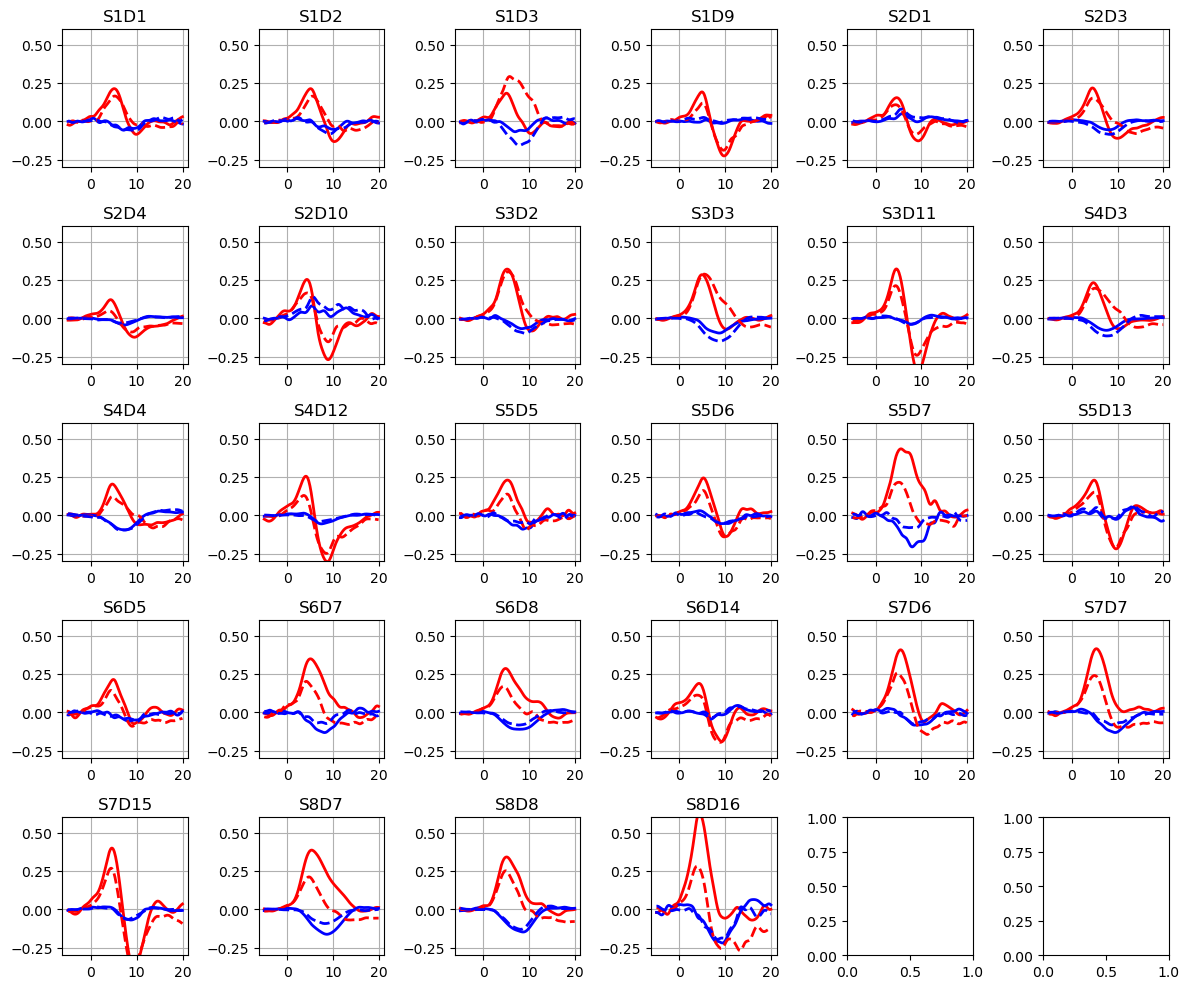

In [10]:
f,ax = p.subplots(5,6, figsize=(12,10))
ax = ax.flatten()
for i_ch, ch in enumerate(blockaverage.channel):
    for ls, trial_type in zip(["-", "--"], blockaverage.trial_type):    
        ax[i_ch].plot(blockaverage.reltime, blockaverage.sel(chromo="HbO", trial_type=trial_type, channel=ch), "r", lw=2, ls=ls)
        ax[i_ch].plot(blockaverage.reltime, blockaverage.sel(chromo="HbR", trial_type=trial_type, channel=ch), "b", lw=2, ls=ls)
    ax[i_ch].grid(1)
    ax[i_ch].set_title(ch.values)
    ax[i_ch].set_ylim(-.3, .6)
    
p.tight_layout()

### Training a LDA classifier with Scikit-Learn

In [11]:
# start with the frequency-filtered, epoched and baseline-corrected concentration data
# discard the samples before the stimulus onset
epochs = all_epochs_blcorrected.sel(reltime=all_epochs_blcorrected.reltime >=0)
# strip units. sklearn would strip them anyway and issue a warning about it.
epochs = epochs.pint.dequantify()

# need to manually tell xarray to create an index for trial_type
epochs = epochs.set_xindex("trial_type")

In [12]:
display(epochs)

<xarray.DataArray 'cfepochs' (epoch: 300, chromo: 2, channel: 28, reltime: 157)>
array([[[[-3.6270e-02, -1.8064e-02,  2.0471e-03, ..., -6.8976e-02,
          -9.4304e-02, -1.2053e-01],
         [ 4.6475e-03,  1.1837e-02,  1.9097e-02, ..., -1.5186e-01,
          -1.5808e-01, -1.6264e-01],
         [ 2.4496e-03,  1.2294e-02,  2.3849e-02, ..., -1.3250e-01,
          -1.4658e-01, -1.6077e-01],
         ...,
         [-4.3450e-02, -3.0909e-02, -1.6201e-02, ..., -3.4983e-01,
          -3.6779e-01, -3.8482e-01],
         [ 2.2952e-02,  3.4524e-02,  4.6622e-02, ..., -2.6465e-01,
          -2.6958e-01, -2.7375e-01],
         [-4.2557e-03,  1.3953e-02,  3.3226e-02, ..., -2.5881e-01,
          -2.7617e-01, -2.9193e-01]],

        [[ 1.5914e-02,  1.3944e-02,  1.0925e-02, ..., -7.7108e-02,
          -7.4584e-02, -6.8965e-02],
         [-1.2916e-02, -9.4326e-03, -4.7285e-03, ..., -5.5005e-02,
          -6.1136e-02, -6.6217e-02],
         [-6.1391e-03, -2.1726e-03, -2.9562e-05, ..., -8.1372e-02,
          -8.0476e-02, -7.8297e-02],
...
         [ 1.5353e-01,  1.5630e-01,  1.5688e-01, ...,  6.7293e-02,
           6.9011e-02,  7.1357e-02],
         [ 2.4956e-01,  2.4903e-01,  2.4447e-01, ...,  7.8465e-02,
           8.7128e-02,  9.4109e-02],
         [ 4.8391e-01,  4.8248e-01,  4.7416e-01, ...,  3.1090e-01,
           3.1703e-01,  3.2376e-01]],

        [[-1.5826e-02, -1.2935e-02, -5.2803e-03, ...,  2.3303e-03,
          -1.2774e-02, -2.7533e-02],
         [-1.3622e-02, -1.8221e-02, -2.3395e-02, ...,  1.1320e-02,
           3.6992e-02,  5.3854e-02],
         [-3.5104e-02, -3.3747e-02, -3.9994e-02, ...,  7.3406e-02,
           5.3683e-02,  3.3055e-02],
         ...,
         [ 1.1524e-02,  1.4339e-02,  1.6261e-02, ...,  9.8163e-02,
           1.0049e-01,  1.0178e-01],
         [-5.6057e-02, -5.8393e-02, -5.9799e-02, ...,  6.0866e-02,
           5.3214e-02,  4.5954e-02],
         [ 3.0087e-02,  3.2592e-02,  3.6472e-02, ..., -5.2315e-03,
          -6.2531e-03, -8.8259e-03]]]])
Coordinates: (3/7)
  * channel     (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
    source      (channel) object 'S1' 'S1' 'S1' 'S1' ... 'S7' 'S8' 'S8' 'S8'
    ...          ...
  * trial_type  (epoch) object 'Tapping/Left' 'Tapping/Left' ... 'Tapping/Right'
Dimensions without coordinates: epoch
Attributes:
    units:    micromolar

In [13]:
X = epochs.stack(features=["chromo", "channel", "reltime"])
display(X)

<xarray.DataArray 'cfepochs' (epoch: 300, features: 8792)>
array([[-0.0363, -0.0181,  0.002 , ..., -0.0126, -0.0093, -0.0072],
       [ 0.109 ,  0.0983,  0.0847, ..., -0.0343, -0.036 , -0.0378],
       [-0.0203, -0.0267, -0.0325, ..., -0.0187, -0.0155, -0.0115],
       ...,
       [ 0.029 ,  0.0078, -0.0164, ..., -0.0117, -0.0013,  0.0085],
       [-0.2281, -0.2284, -0.2273, ...,  0.0104,  0.0108,  0.0135],
       [ 0.2505,  0.2608,  0.2643, ..., -0.0052, -0.0063, -0.0088]])
Coordinates: (3/8)
    source      (features) object 'S1' 'S1' 'S1' 'S1' ... 'S8' 'S8' 'S8' 'S8'
    detector    (features) object 'D1' 'D1' 'D1' 'D1' ... 'D16' 'D16' 'D16'
    ...          ...
  * reltime     (features) float64 0.0 0.128 0.256 0.384 ... 19.71 19.84 19.97
Dimensions without coordinates: epoch
Attributes:
    units:    micromolar

In [14]:
y = xr.apply_ufunc(LabelEncoder().fit_transform, X.trial_type)
display(y)

<xarray.DataArray 'trial_type' (epoch: 300)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
    subject     (epoch) <U6 'sub-01' 'sub-01' 'sub-01' ... 'sub-05' 'sub-05'
  * trial_type  (epoch) object 'Tapping/Left' 'Tapping/Left' ... 'Tapping/Right'
Dimensions without coordinates: epoch

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)
classifier = LinearDiscriminantAnalysis(n_components=1).fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8111111111111111


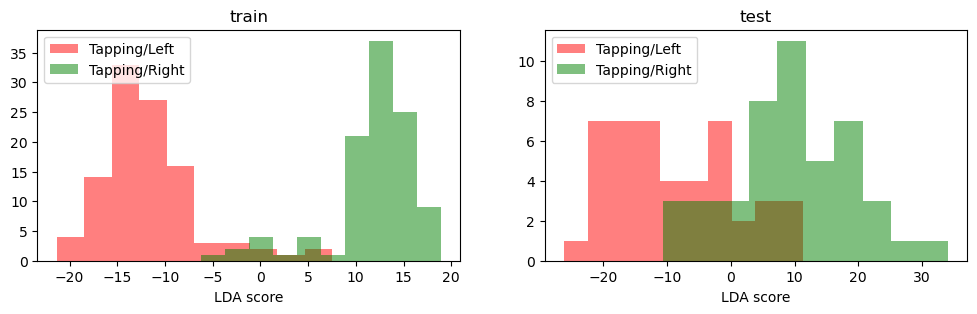

In [17]:
f,ax = p.subplots(1,2, figsize=(12,3))
for trial_type, c in zip(["Tapping/Left", "Tapping/Right"], ["r", "g"]):
    kw  = dict(alpha=.5, fc=c, label=trial_type)
    ax[0].hist(classifier.decision_function(X_train.sel(trial_type=trial_type)),**kw)
    ax[1].hist(classifier.decision_function(X_test.sel(trial_type=trial_type)), **kw)

ax[0].set_xlabel("LDA score"); ax[1].set_xlabel("LDA score"); ax[0].set_title("train"); ax[1].set_title("test"); ax[0].legend(ncol=1,loc="upper left"); ax[1].legend(ncol=1, loc="upper left");